In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import math
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
from sklearn import cross_validation
from time import time
import xgboost as xgb
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report

In [2]:
df = pd.read_table('../data/brcaTrainExpr.txt', index_col = 'GENE')
df = df.transpose()
X = np.array(df)
df.head()

dfT = pd.read_table('../data/brcaTestExpr.txt', index_col = 'GENE')
dfT = dfT.transpose()
XT = np.array(dfT)
dfT.head()

dfy = pd.read_table('../data/brcaTrainPheno.txt')
y = np.where(dfy.RelapseGroup == 'Relapse', 1, 0)
y[:5]

dfyT = pd.read_table('../data/brcaTestPheno.txt')
yT = np.where(dfyT.RelapseGroup == 'Relapse', 1, 0)
yT[:5]

def WRST(X,y): #X is feature matrix, y is binary label vector

    num_zeros = sum(y == 0) # Number of NoRelapse patients
    num_ones = len(y) - num_zeros # Number of Relapse patients
    
    #Use Wilcoxon rank-sum test to find most differentially expressed genes
    W = np.array(range(X.shape[1])) #Create W vector whose length = # of genes (aka number of columns)
    
    for i in range(X.shape[1]): #for each gene
        ranks = ss.rankdata(X[:,i],method='average')  # rank patients from least expressed to most expressed
        
        W[i] = sum(ranks[np.nonzero(y)]) #Add together gene i's rank for all patients who relapse
    
    #For binary label, sum up positive labels & negative labels (this equals the mean)
    # When the two samples are sufficiently large, the W statistic is approximately normal N(μ, σ) where
    m = num_ones * (len(y) + 1) / 2. # mu =  n1 * (n + 1) / 2 and 
    s = math.sqrt((num_zeros * num_ones * (len(y) + 1)) / 12.) # var = n1 * n2 * (n + 1) / 12
    
    pval = np.array(range(X.shape[1]), float) # Create empty pval array
    
    #calculate p-values for each gene
    for i in range(len(W)):
        if W[i] <= m:
            pval[i] = 2.*ss.norm.cdf(W[i],m,s)
        else:
            pval[i] = 2.*(1-ss.norm.cdf(W[i],m,s))
    
    #sort p-values
    sort = np.argsort(pval)
    
    return sort

sort = WRST(X, y)

dfw = df[df.columns[sort]]
dfTw = dfT[dfT.columns[sort]]
Xw = np.array(dfw)
XTw = np.array(dfTw)

In [3]:
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [3,5,7], 'learning_rate': [0.01,0.05,0.1]}
ind_params = {'n_estimators': 7500, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
              'objective': 'binary:logistic', 'scale_pos_weight':1.5}

optimizing_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), cv_params, cv = 5, n_jobs = -1)
% time optimizing_GBM.fit(Xw[:,:1000], y)
ind_params.update(optimizing_GBM.best_params_)
optimized_GBM = xgb.XGBClassifier(**ind_params)
optimized_GBM.fit(Xw[:,:1000], y)

CPU times: user 42.6 s, sys: 2.31 s, total: 44.9 s
Wall time: 1h 8min 30s


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=5,
       min_child_weight=5, missing=None, n_estimators=7500, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1.5, seed=0, silent=True, subsample=0.8)

In [4]:
test_pp = optimized_GBM.predict_proba(XTw[:,:1000])
print('Null Accuracy   :', 137./212)
print('XGBoost Accuracy:',optimized_GBM.score(XTw[:,:1000], yT))
print('')
print(classification_report(yT, optimized_GBM.predict(XTw[:,:1000]), labels=[1,0]))
print('')
conmat = np.array(confusion_matrix(yT, optimized_GBM.predict(XTw[:,:1000]), labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['Relapse', 'NoRelapse'],
                         columns=['predicted_Relapse','predicted_NoRelapse'])
confusion

('Null Accuracy   :', 0.6462264150943396)
('XGBoost Accuracy:', 0.68396226415094341)

             precision    recall  f1-score   support

          1       0.62      0.28      0.39        75
          0       0.70      0.91      0.79       137

avg / total       0.67      0.68      0.65       212




,predicted_Relapse,predicted_NoRelapse
Relapse,21,54
NoRelapse,13,124


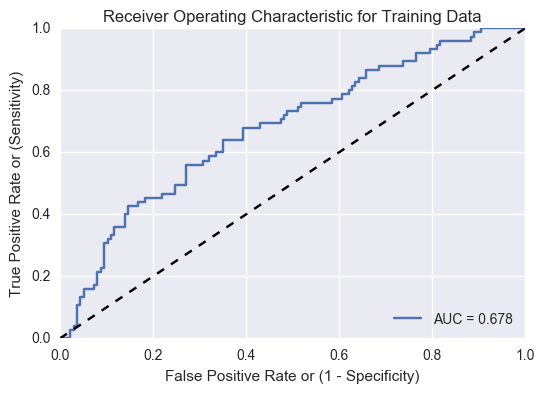

0.677664233577

222332_at


In [5]:
fpr, tpr, thresholds = roc_curve(yT, test_pp[:,1])
roc_auc = auc(fpr, tpr)
%matplotlib inline
plt.plot(fpr, tpr, label='AUC = %0.3f' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate or (1 - Specificity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic for Training Data')
plt.legend(loc="lower right")
plt.show()
print(roc_auc)
print('')
print(dfw.columns[np.argmax(optimized_GBM.feature_importances_)])

In [6]:
sort_ix = sorted(range(len(optimized_GBM.feature_importances_)), key=lambda i: optimized_GBM.feature_importances_[i], reverse=True)

In [7]:
for i in range(5):
    print(dfw.columns[sort_ix[i]])

222332_at
215141_at;NOP14-AS1
212929_s_at
207056_s_at;SLC4A8
208338_at;P2RX3


In [8]:
print 'Sensitivity/Recall/TPR (Correct Relapse Predictions / Total Relapse):', float(conmat[0][0]) / conmat.sum(axis=1)[0]
print ''
print 'Specificity/TNR (Correct NoRelapse Predictions / Total NoRelapse):', float(conmat[1][1]) / conmat.sum(axis=1)[1]
print ''
print 'Precision (Correct Relapse Predictions / Total Relapse Predictions):', float(conmat[0][0]) / conmat.sum(axis=0)[0]
print ''
print 'FPR (Incorrect Relapse Predictions / Total NoRelapse):', float(conmat[1][0]) / conmat.sum(axis=1)[1]

Sensitivity/Recall/TPR (Correct Relapse Predictions / Total Relapse): 0.28

Specificity/TNR (Correct NoRelapse Predictions / Total NoRelapse): 0.905109489051

Precision (Correct Relapse Predictions / Total Relapse Predictions): 0.617647058824

FPR (Incorrect Relapse Predictions / Total NoRelapse): 0.0948905109489
